# Buy it Again

- https://www.kaggle.com/code/lichtlab/do-customers-buy-the-same-products-again
    



In [1]:
import os
import gc
import math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
from scipy.optimize import curve_fit
from joblib import dump, load
import scipy.stats as stats
import seaborn as sns
tqdm.pandas()

import sys
sys.path.insert(0, '../../')

from utils.preprocess import *

In [2]:

folder = '../../../data/'

art_df = pd.read_csv(os.path.join(folder, "articles.csv"))
cus_df = pd.read_csv(os.path.join(folder, "customers.csv"))
trans_df = pd.read_csv(os.path.join(folder, "transactions_train.csv"))

trans_df = make_weeknum_col(trans_df)
# week_num 0 is latest week of the transaction
train_df, val_df = split_train_valid(trans_df, 0)
# val_df = valid2submission(val_df)


In [3]:
use_cols = ['t_dat', 'customer_id', 'article_id']
train_df = train_df[use_cols]

In [4]:
# https://www.kaggle.com/code/lichtlab/do-customers-buy-the-same-products-again
art_df['idxgrp_idx_prdtyp'] = art_df['index_group_name'] + '_' + art_df['index_name'] + '_' + art_df['product_type_name'] 
display(art_df.astype(str).describe().T)

temp_df = art_df.groupby('prod_name')['idxgrp_idx_prdtyp'].count()
print('같은 prod_name에서의 다른 idxgrp_idx_prdtyp:');print()
print(list(temp_df[temp_df == 2].index)[:10])
print();print()
print('같은 idxgrp_idx_prdtyp에서의 다른 prod_name:');print()
print('', list(art_df[art_df.idxgrp_idx_prdtyp == art_df.idxgrp_idx_prdtyp.iloc[0]]['prod_name'].unique())[:10])

,count,unique,top,freq
article_id,105542,105542,108775015,1
product_code,105542,47224,783707,75
prod_name,105542,45875,Dragonfly dress,98
product_type_no,105542,132,272,11169
product_type_name,105542,131,Trousers,11169
product_group_name,105542,19,Garment Upper body,42741
graphical_appearance_no,105542,30,1010016,49747
graphical_appearance_name,105542,30,Solid,49747
colour_group_code,105542,50,9,22670
colour_group_name,105542,50,Black,22670


같은 prod_name에서의 다른 idxgrp_idx_prdtyp:

['& Denim Boyfriend LW denim', '&DENIM Shaping bootcut', '&DENIM Skinny RW milo zip', '&DENIM+ Girlfriend RW', '&DENIM+ Jacket oversized', '&Denim Lou shirtdress.', '&Denim+ Embrace HW Ankle', '&Denim+ Embrace HW Trash', '&Denim+ Lou shirtdress', '&denim festive HW ankle']


같은 idxgrp_idx_prdtyp에서의 다른 prod_name:

 ['Strap top', 'Strap top (1)', 'Beyonce cropped tank', 'Moa tanktop', 'Halter', 'Jess', 'cooper tank', 'Tika (1)', 'Tika', 'Robin']


In [5]:

use_cols = ['article_id', 'prod_name', 'idxgrp_idx_prdtyp']
sample_art_df = art_df[use_cols]
train_df = pd.merge(train_df, sample_art_df, how='left', on='article_id')
train_df.head()

,t_dat,customer_id,article_id,prod_name,idxgrp_idx_prdtyp
0,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,663713001,Atlanta Push Body Harlow,Ladieswear_Lingeries/Tights_Underwear body
1,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,541518023,Rae Push (Melbourne) 2p,Ladieswear_Lingeries/Tights_Bra
2,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,505221004,Inca Jumper,Divided_Divided_Sweater
3,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687003,W YODA KNIT OL OFFER,Ladieswear_Ladieswear_Sweater
4,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687004,W YODA KNIT OL OFFER,Ladieswear_Ladieswear_Sweater


In [6]:
train_df['t_dat'] = pd.to_datetime(train_df['t_dat'])
train_df['trans_idx'] = train_df.index

print("총 거래 수", len(train_df))
aid_train_df = train_df.drop_duplicates(subset=["t_dat", "customer_id", "article_id"], keep='last')
pname_train_df = train_df.drop_duplicates(subset=["t_dat", "customer_id", "prod_name"], keep='last')
idxgrp_train_df = train_df.drop_duplicates(subset=["t_dat", "customer_id", "idxgrp_idx_prdtyp"], keep='last')
print("중복제거")
print(f"article_id: {len(aid_train_df)}")
print(f"prod_name: {len(pname_train_df)}")
print(f"idxgrp_idx_prdtyp : {len(idxgrp_train_df)}")

## 다른 열 유지 시, mean on price, max on channel_id
## 같은 날짜 같은 고객 같은 상품 수량 2 이상 구매 합치기
# train_df = train_df.groupby(['article_id', 'customer_id','t_dat'])
# price_df = train_df.price.mean()
# price_df = pd.DataFrame(price_df)
# channel_df = train_df.sales_channel_id.max()
# train_df = pd.merge(price_df, channel_df, left_index=True, right_index=True, how="left")
# train_df = train_df.reset_index()




총 거래 수 31548013
중복제거
article_id: 28358603
prod_name: 26462145
idxgrp_idx_prdtyp : 21149355


In [7]:
def make_time_interval_col(train_df, col='article_id'):
    train_df = train_df.set_index(['customer_id', col])
    train_df = train_df.sort_values('t_dat')
    train_df = train_df.sort_index()

    train_df[f'{col}_lastdate'] = train_df.groupby(level=[0,1])['t_dat'].shift(1)
    train_df[f'{col}_dist'] = (train_df['t_dat'] - train_df[f'{col}_lastdate']).dt.days

    train_df = train_df.reset_index()
    return train_df

# day_intervals = train_df.loc[train_df['dist'].notna(), 'dist'].values

In [8]:
aid_train_df = make_time_interval_col(aid_train_df, 'article_id')
pname_train_df = make_time_interval_col(pname_train_df, 'prod_name')
idxgrp_train_df = make_time_interval_col(idxgrp_train_df, 'idxgrp_idx_prdtyp')

## RCP - Repeat Customer Probability

- 상품 A를 2번 이상 고매한 고객의 수 / 상품 A를 최소 한번이라도 구매한 고객 수

- Formula:\
$$ P_{A_i}(t_{k+1}|t_{1},t_{2}, ... t_{k}) \approx Q(A_{i}) \approx RCP_{A_{i}} = {{\mathrm{\# \ of \ customers \ who \ bought \ product \ A_{i} \ more \ than \ once}}\over{\mathrm{\# \ of \ customers \ who \ bought \ product \ A\_{i} \ at \ least \ once}}} $$

In [9]:
def groupby_cid_artinfo(transaction_df, article_info):
    grouped = transaction_df.groupby([f'{article_info}', 'customer_id'])['t_dat'].count().reset_index()
    grouped = grouped.rename(columns={'t_dat': 'cnt'})
    grouped = grouped.sort_values('cnt', ascending= False)
    return grouped

def make_rcp_df(grouped_df, article_info):

    denom = pd.DataFrame(grouped_df.groupby(f'{article_info}')['customer_id'].nunique()).reset_index()
    denom = denom.rename(columns={'customer_id': 'denom_customer'})

    numer = pd.DataFrame(grouped_df[grouped_df.cnt > 1].groupby(f'{article_info}')['customer_id'].nunique()).reset_index()
    numer = numer.rename(columns={'customer_id': 'num_customer'})

    rcp_df = pd.merge(denom, numer, on= f'{article_info}')
    rcp_df['rcp'] = rcp_df['num_customer']/rcp_df['denom_customer']
    return rcp_df



In [10]:
aid_g_df = groupby_cid_artinfo(aid_train_df, 'article_id')
pname_g_df = groupby_cid_artinfo(pname_train_df, 'prod_name')
prdtyp_g_df = groupby_cid_artinfo(idxgrp_train_df, 'idxgrp_idx_prdtyp')

In [11]:
aid_g_df = make_rcp_df(aid_g_df, 'article_id')
pname_g_df = make_rcp_df(pname_g_df, 'prod_name')
prdtyp_g_df = make_rcp_df(prdtyp_g_df, 'idxgrp_idx_prdtyp')

In [12]:
def describe_vis(rcp_df, color = 'r'):
    numeric_cols = ['denom_customer', 'num_customer', 'rcp']
    display(rcp_df[numeric_cols].describe())
    rcp_df = rcp_df.sort_values('rcp')
    rcp_df['rcp'].hist(bins=500, color = color)


,denom_customer,num_customer,rcp
count,62599.000000,62599.000000,62599.000000
mean,420.078596,18.068228,0.044966
std,779.697395,62.415162,0.045307
min,1.000000,1.000000,0.001621
25%,67.000000,2.000000,0.022079
50%,182.000000,5.000000,0.035354
75%,471.000000,16.000000,0.055138
max,32068.000000,6378.000000,1.000000


,denom_customer,num_customer,rcp
count,30807.000000,30807.000000,30807.000000
mean,785.446165,54.099523,0.051629
std,2165.559865,284.186002,0.044378
min,1.000000,1.000000,0.001621
25%,77.000000,2.000000,0.027027
50%,213.000000,8.000000,0.043478
75%,649.000000,29.000000,0.065114
max,76918.000000,20803.000000,1.000000


,denom_customer,num_customer,rcp
count,469.000000,469.000000,469.000000
mean,27649.420043,8272.590618,0.098492
std,72425.456837,30127.965554,0.090103
min,4.000000,1.000000,0.004082
25%,515.000000,18.000000,0.040929
50%,2646.000000,169.000000,0.068543
75%,12991.000000,1429.000000,0.119331
max,520563.000000,259551.000000,0.500000


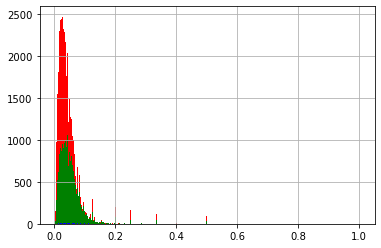

In [13]:
describe_vis(aid_g_df, 'r')
describe_vis(pname_g_df, 'g')
describe_vis(prdtyp_g_df, 'b')

,denom_customer,num_customer,rcp
count,469.000000,469.000000,469.000000
mean,27649.420043,8272.590618,0.098492
std,72425.456837,30127.965554,0.090103
min,4.000000,1.000000,0.004082
25%,515.000000,18.000000,0.040929
50%,2646.000000,169.000000,0.068543
75%,12991.000000,1429.000000,0.119331
max,520563.000000,259551.000000,0.500000


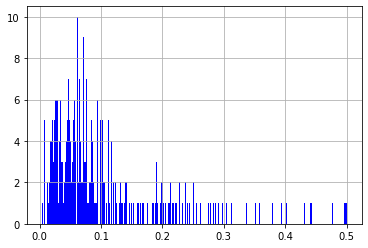

In [14]:
describe_vis(prdtyp_g_df, 'b')

In [15]:
prdtyp_g_df.sort_values('rcp')

,idxgrp_idx_prdtyp,denom_customer,num_customer,rcp
288,Ladieswear_Ladies Accessories_Wireless earphon...,245,1,0.004082
91,"Baby/Children_Children Accessories, Swimwear_S...",173,1,0.005780
191,Divided_Divided_Cross-body bag,555,4,0.007207
235,Divided_Divided_Umbrella,132,1,0.007576
316,Ladieswear_Ladieswear_Necklace,128,1,0.007812
...,...,...,...,...
234,Divided_Divided_Trousers,424452,200200,0.471667
338,Ladieswear_Ladieswear_Sweater,473259,225400,0.476272
301,Ladieswear_Ladieswear_Dress,476374,236441,0.496335
345,Ladieswear_Ladieswear_Trousers,520563,259551,0.498597


In [16]:
def get_repeat_purchasable(rcp_df, rcp_threshold = 0.2, denom_customer_num=None, denom_customer_prop=None):
    # denom_customer_num: number of people who bouhgt the product at least once
    if denom_customer_prop and denom_customer_num is None:
        denom_customer_num = rcp_df.denom_customer.quantile(denom_customer_prop)
    elif denom_customer_prop is None and denom_customer_num is None:
        denom_customer_num = 0
    print(f'재구매가능 상품의 최소 고객수: {denom_customer_num}')
    repeat_purchasable_df = rcp_df[(rcp_df.rcp > rcp_threshold) & 
                                (rcp_df.denom_customer >= denom_customer_num)]
    return repeat_purchasable_df

In [17]:
rcp_threshold = 0.2
rp_aid = get_repeat_purchasable(aid_g_df,rcp_threshold, denom_customer_num=30)
rp_pname = get_repeat_purchasable(pname_g_df,rcp_threshold, denom_customer_num=30)
rp_prdtyp = get_repeat_purchasable(prdtyp_g_df,rcp_threshold, denom_customer_num=30)

재구매가능 상품의 최소 고객수: 30
재구매가능 상품의 최소 고객수: 30
재구매가능 상품의 최소 고객수: 30


In [18]:
print("article_id 개수: ",len(art_df.article_id.unique()))
print("repeat_purchasable article_id 개수: ", len(rp_aid))
rp_aid = pd.merge(rp_aid, art_df[use_cols], on='article_id', how='left')
rp_aid.sort_values('rcp', ascending=False).head(23)

article_id 개수:  105542
repeat_purchasable article_id 개수:  23


,article_id,denom_customer,num_customer,rcp,prod_name,idxgrp_idx_prdtyp
8,689561001,35,9,0.257143,SC - MAJOR boot high,Ladieswear_Ladieswear_Boots
15,784273001,130,33,0.253846,Gatito fur coat,Ladieswear_Ladieswear_Coat
5,642675002,85,21,0.247059,Kardasian puffer,Divided_Divided_Jacket
21,884726001,55,13,0.236364,POW Chiba Dress,Ladieswear_Ladieswear_Dress
22,886862002,43,10,0.232558,Jupiter short parka CN,Ladieswear_Ladieswear_Jacket
10,698387001,1195,271,0.226778,&DENIM+ Skinny Shaping HW,Ladieswear_Ladieswear_Trousers
19,838712002,31,7,0.225806,PQ ELLIE SILK BLOUSE,Ladieswear_Ladieswear_Shirt
0,160442007,9801,2180,0.222426,3p Sneaker Socks,Ladieswear_Lingeries/Tights_Socks
16,786998001,90,20,0.222222,PQ FIONA CASH POLO,Ladieswear_Ladieswear_Sweater
11,703371001,376,81,0.215426,Guela jaquard,Ladieswear_Ladieswear_Trousers


In [19]:
print("prod_name 개수: ",len(art_df.prod_name.unique()))
print("repeat_purchasable prod_name 개수: ", len(rp_pname))
rp_pname.sort_values('rcp', ascending=False).head(23)

prod_name 개수:  45875
repeat_purchasable prod_name 개수:  23


,prod_name,denom_customer,num_customer,rcp
12,&DENIM Jeggings HW,6272,1810,0.288584
13572,Jade HW Skinny Denim TRS,76918,20803,0.270457
365,3p Sneaker Socks,16663,4490,0.269459
24191,S.Skinny L.W Epic,14124,3655,0.258779
24403,SC - MAJOR boot high,35,9,0.257143
11484,Gatito fur coat,130,33,0.253846
18,&DENIM Skinny HW Ancle Vanessa,2830,693,0.244876
1354,Amy Cord Skinny Slacks,46,11,0.239130
40,&DENIM+ Skinny Shaping HW,1753,419,0.239019
21285,POW Chiba Dress,55,13,0.236364


In [20]:
print("idxgrp_idx_prdtyp 개수: ",len(art_df.idxgrp_idx_prdtyp.unique()))
print("repeat_purchasable idxgrp_idx_prdtyp 개수: ", len(rp_prdtyp))
rp_prdtyp.sort_values('rcp', ascending=False).head(30)

idxgrp_idx_prdtyp 개수:  523
repeat_purchasable idxgrp_idx_prdtyp 개수:  55


,idxgrp_idx_prdtyp,denom_customer,num_customer,rcp
345,Ladieswear_Ladieswear_Trousers,520563,259551,0.498597
301,Ladieswear_Ladieswear_Dress,476374,236441,0.496335
338,Ladieswear_Ladieswear_Sweater,473259,225400,0.476272
234,Divided_Divided_Trousers,424452,200200,0.471667
292,Ladieswear_Ladieswear_Blouse,398139,176512,0.443343
353,Ladieswear_Lingeries/Tights_Bra,335941,147987,0.440515
344,Ladieswear_Ladieswear_Top,419021,180755,0.431375
375,Ladieswear_Lingeries/Tights_Underwear bottom,293323,118257,0.403163
192,Divided_Divided_Dress,333925,134353,0.402345
352,Ladieswear_Lingeries/Tights_Bikini top,333941,131554,0.393944


# Modified Poisson-Gamma Model (MPG)


- gamma: shape, rate = (1/scale)


- Formula:
  $$ P_{A_i}(t_{k+1}|t_{1},t_{2}, ... t_{k}) \approx Q(A_{i}) \times R_{A_i}(t_{k+1}|t_{1},t_{2}, ... t_{k}, A_{i} = 1) $$



- $R_{A_{i}, C_{j}}(t)$: is a homogeneous Poisson’s process with repeat purchase rate $\lambda$. (they assume that successive repeat purchases are not correlated with each other.)
    $$R_{A_{i}, C_{j}}(t)=\sum_{m=1}^{\infty} \frac{\lambda_{A_{i}, C_{j}}^{m} \exp \left(\lambda_{A_{i}, C_{j}}\right)}{m !}, \ \ t>0$$ 

- m: number of expected future purchases
- gamma prior on $\lambda$, assume that $\lambda$ across all customers follows a Gamma distribution with shape $\alpha$ and rate $\beta$.
    - when $t > 2 \times t_{mean}$
$$\lambda_{A_{i}, C_{j}}=\frac{k+\alpha_{A_{i}}} {t+\beta_{A_{i}}}, \ \ t>0$$ 
        - In the PG model, the parameters of the product-specific gamma distributions are estimated in an empirical fashion by fitting them to the maximum likelihood estimates of the purchase rates of repeat purchasing customers.
        - $\alpha_{A_{i}}$, $\beta_{A_{i}}$ : the shape and rate parameters of the gamma prior of product ${A_{i}}$
        - k : the number of purchases of product ${A_{i}}$ by customer ${C_{j}}$; 
        - t : elapsed time between the **first purchase** of product ${A_{i}}$ by customer ${C_{j}}$ and the current time

    - when $t < 2 \times t_{mean}$: 
      $$ \lambda_{A_{i},C_{j}} = {{k+\alpha_{A_{i}}} \over {t_{purch} + 2  |t_{mean} \  - \ t| + \beta_{A_{i}}}} , \ \, t>0 $$
        - $t_{mean}$: estimated mean repeat purchase time interval between successive purchases of product Ai by customer Cj 
        - $t_{purch}$ :elapsed time interval between the first and last purchase of product Ai by customer Cj 
        - t : the elapsed time interval between the **last purchase** of product Ai by customer Cj and the current time
- $ Q(A\_{i}) $: same with ATD/RCP


In [21]:
# train_df = pd.merge(train_df, aid_train_df, 
#                      on='trans_idx', how = 'left', 
#                      suffixes=('', '_DROP')).filter(regex='^(?!.*_DROP)')
# train_df = pd.merge(train_df, pname_train_df, 
#                      on='trans_idx', how = 'left', 
#                      suffixes=('', '_DROP')).filter(regex='^(?!.*_DROP)')
# train_df = pd.merge(train_df, idxgrp_train_df, 
#                      on='trans_idx', how = 'left', 
#                      suffixes=('', '_DROP')).filter(regex='^(?!.*_DROP)')
# del aid_train_df, pname_train_df, idxgrp_train_df
# import gc; gc.collect()


In [22]:
aid_train_df = aid_train_df[aid_train_df.article_id.isin(rp_aid.article_id)]
pname_train_df = pname_train_df[pname_train_df.prod_name.isin(rp_pname.prod_name)]
idxgrp_train_df = idxgrp_train_df[idxgrp_train_df.idxgrp_idx_prdtyp.isin(rp_prdtyp.idxgrp_idx_prdtyp)]

In [23]:
print(len(aid_train_df)/len(train_df))
print(len(pname_train_df)/len(train_df))
print(len(idxgrp_train_df)/len(train_df))
print(len(rp_prdtyp)/len(art_df.idxgrp_idx_prdtyp.unique()))

0.001211486758294413
0.01129465744799839
0.5476306225688445
0.10516252390057361


In [24]:
def get_rp_cus_item(transaction_df, rp_df, col, min_repeat_time = 4):
    rp_cus_item = []
    for cur_item in tqdm(rp_df[col].values):
        rp_customers = transaction_df[(transaction_df[col] == cur_item) & 
                                      (transaction_df[f'{col}_dist'].notna())].customer_id.unique() 

        for cus_idx in range(len(rp_customers)):
            cur_customer = rp_customers[cus_idx]
            cur_trans_idx = transaction_df[(transaction_df[col] == cur_item) & 
                                           (transaction_df.customer_id == cur_customer)]['trans_idx']
            if len(cur_trans_idx) >= min_repeat_time:
                rp_cus_item.append((cur_item, cur_customer, len(cur_trans_idx), list(cur_trans_idx)))
    return rp_cus_item

In [25]:
rp_cus_aid = get_rp_cus_item(aid_train_df, rp_aid, 'article_id')

100%|████████████████████████████████████████████████████████████████| 23/23 [00:10<00:00,  2.14it/s]


In [26]:
rp_cus_aid = pd.DataFrame(rp_cus_aid, columns=['customer_id', 'article_id', 'repeated', 'trans_idxes'])
rp_cus_aid = rp_cus_aid.sort_values('repeated', ascending=False)

In [27]:
aid_train_df[aid_train_df.trans_idx.isin(rp_cus_aid.iloc[0].trans_idxes)]

,customer_id,article_id,t_dat,prod_name,idxgrp_idx_prdtyp,trans_idx,article_id_lastdate,article_id_dist
22230251,c87f63ab246a0d5c5b1c5f87cf694d9a35a9110030f0a1...,368979001,2018-10-10,ED Long leggings,Ladieswear_Ladieswear_Leggings/Tights,970229,NaT,NaN
22230252,c87f63ab246a0d5c5b1c5f87cf694d9a35a9110030f0a1...,368979001,2018-11-10,ED Long leggings,Ladieswear_Ladieswear_Leggings/Tights,2335694,2018-10-10,31.0
22230253,c87f63ab246a0d5c5b1c5f87cf694d9a35a9110030f0a1...,368979001,2018-12-31,ED Long leggings,Ladieswear_Ladieswear_Leggings/Tights,4405804,2018-11-10,51.0
22230254,c87f63ab246a0d5c5b1c5f87cf694d9a35a9110030f0a1...,368979001,2019-04-18,ED Long leggings,Ladieswear_Ladieswear_Leggings/Tights,8946847,2018-12-31,108.0
22230255,c87f63ab246a0d5c5b1c5f87cf694d9a35a9110030f0a1...,368979001,2019-05-26,ED Long leggings,Ladieswear_Ladieswear_Leggings/Tights,10852246,2019-04-18,38.0
22230256,c87f63ab246a0d5c5b1c5f87cf694d9a35a9110030f0a1...,368979001,2019-07-03,ED Long leggings,Ladieswear_Ladieswear_Leggings/Tights,13255262,2019-05-26,38.0
22230257,c87f63ab246a0d5c5b1c5f87cf694d9a35a9110030f0a1...,368979001,2019-10-01,ED Long leggings,Ladieswear_Ladieswear_Leggings/Tights,17376528,2019-07-03,90.0
22230258,c87f63ab246a0d5c5b1c5f87cf694d9a35a9110030f0a1...,368979001,2019-10-03,ED Long leggings,Ladieswear_Ladieswear_Leggings/Tights,17488614,2019-10-01,2.0
22230259,c87f63ab246a0d5c5b1c5f87cf694d9a35a9110030f0a1...,368979001,2019-12-04,ED Long leggings,Ladieswear_Ladieswear_Leggings/Tights,19861678,2019-10-03,62.0
22230260,c87f63ab246a0d5c5b1c5f87cf694d9a35a9110030f0a1...,368979001,2019-12-22,ED Long leggings,Ladieswear_Ladieswear_Leggings/Tights,20500872,2019-12-04,18.0


In [28]:
aid_train_df[aid_train_df.trans_idx.isin(rp_cus_aid.iloc[1].trans_idxes)]

,customer_id,article_id,t_dat,prod_name,idxgrp_idx_prdtyp,trans_idx,article_id_lastdate,article_id_dist
5161621,2e66e7ab67d6d29f30c39c2049bcbb8103b6b2a2a34705...,624257001,2018-09-21,&DENIM+ Skinny shaping RW,Ladieswear_Ladieswear_Trousers,56967,NaT,NaN
5161622,2e66e7ab67d6d29f30c39c2049bcbb8103b6b2a2a34705...,624257001,2019-01-08,&DENIM+ Skinny shaping RW,Ladieswear_Ladieswear_Trousers,4691066,2018-09-21,109.0
5161623,2e66e7ab67d6d29f30c39c2049bcbb8103b6b2a2a34705...,624257001,2019-02-12,&DENIM+ Skinny shaping RW,Ladieswear_Ladieswear_Trousers,6105330,2019-01-08,35.0
5161624,2e66e7ab67d6d29f30c39c2049bcbb8103b6b2a2a34705...,624257001,2019-04-16,&DENIM+ Skinny shaping RW,Ladieswear_Ladieswear_Trousers,8827185,2019-02-12,63.0
5161625,2e66e7ab67d6d29f30c39c2049bcbb8103b6b2a2a34705...,624257001,2019-05-16,&DENIM+ Skinny shaping RW,Ladieswear_Ladieswear_Trousers,10300582,2019-04-16,30.0
5161626,2e66e7ab67d6d29f30c39c2049bcbb8103b6b2a2a34705...,624257001,2019-09-06,&DENIM+ Skinny shaping RW,Ladieswear_Ladieswear_Trousers,16302918,2019-05-16,113.0
5161627,2e66e7ab67d6d29f30c39c2049bcbb8103b6b2a2a34705...,624257001,2019-11-07,&DENIM+ Skinny shaping RW,Ladieswear_Ladieswear_Trousers,18735277,2019-09-06,62.0
5161628,2e66e7ab67d6d29f30c39c2049bcbb8103b6b2a2a34705...,624257001,2019-11-13,&DENIM+ Skinny shaping RW,Ladieswear_Ladieswear_Trousers,18916812,2019-11-07,6.0
5161629,2e66e7ab67d6d29f30c39c2049bcbb8103b6b2a2a34705...,624257001,2020-01-02,&DENIM+ Skinny shaping RW,Ladieswear_Ladieswear_Trousers,20829140,2019-11-13,50.0
5161630,2e66e7ab67d6d29f30c39c2049bcbb8103b6b2a2a34705...,624257001,2020-02-10,&DENIM+ Skinny shaping RW,Ladieswear_Ladieswear_Trousers,22210634,2020-01-02,39.0


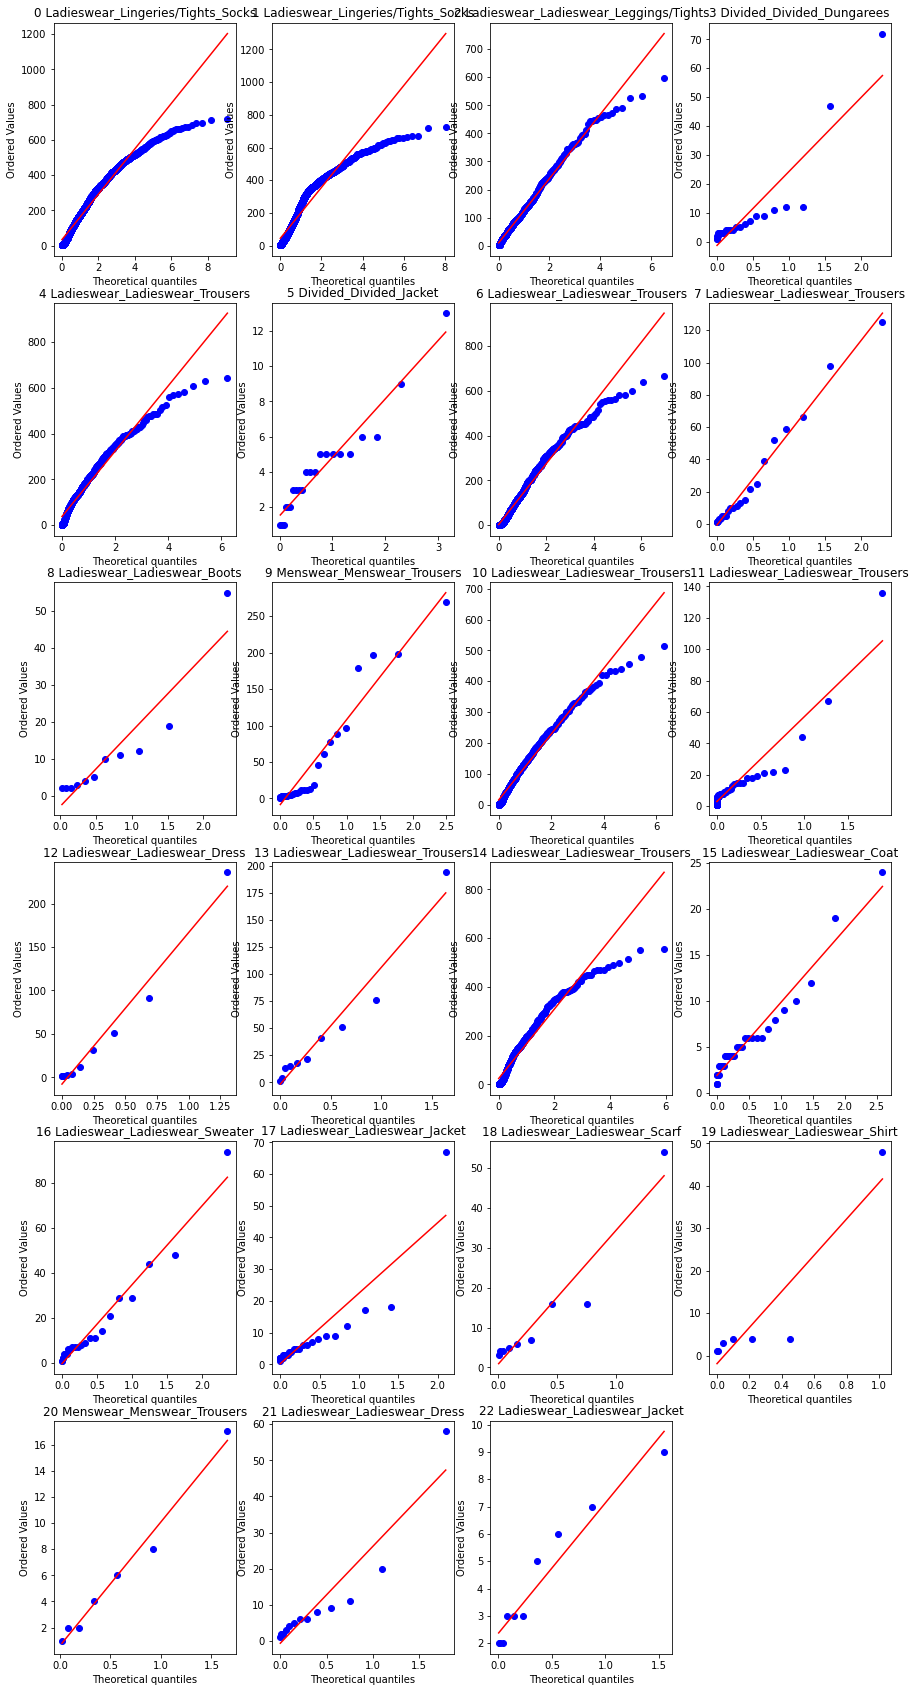

In [29]:
fig = plt.figure(figsize=(15,30))
for i in range(len(rp_aid)):
    cur_aid =  rp_aid.article_id.iloc[i]
    cur_aid_train_df = aid_train_df[aid_train_df.article_id == cur_aid]
    cur_dist = cur_aid_train_df.article_id_dist
    cur_dist = cur_dist[~np.isnan(cur_dist)]
    
    shape, loc, scale = stats.gamma.fit(cur_dist)
    #print(shape, loc, scale)
    ax = fig.add_subplot(6, 4, i+1)
    res = stats.probplot(cur_dist, dist=stats.gamma, sparams=(shape,), plot=plt)
    title = art_df[art_df.article_id == cur_aid]['idxgrp_idx_prdtyp'].values[0]
    ax.set_title(f"{i} {title}")
#     ax.imshow(res)
        

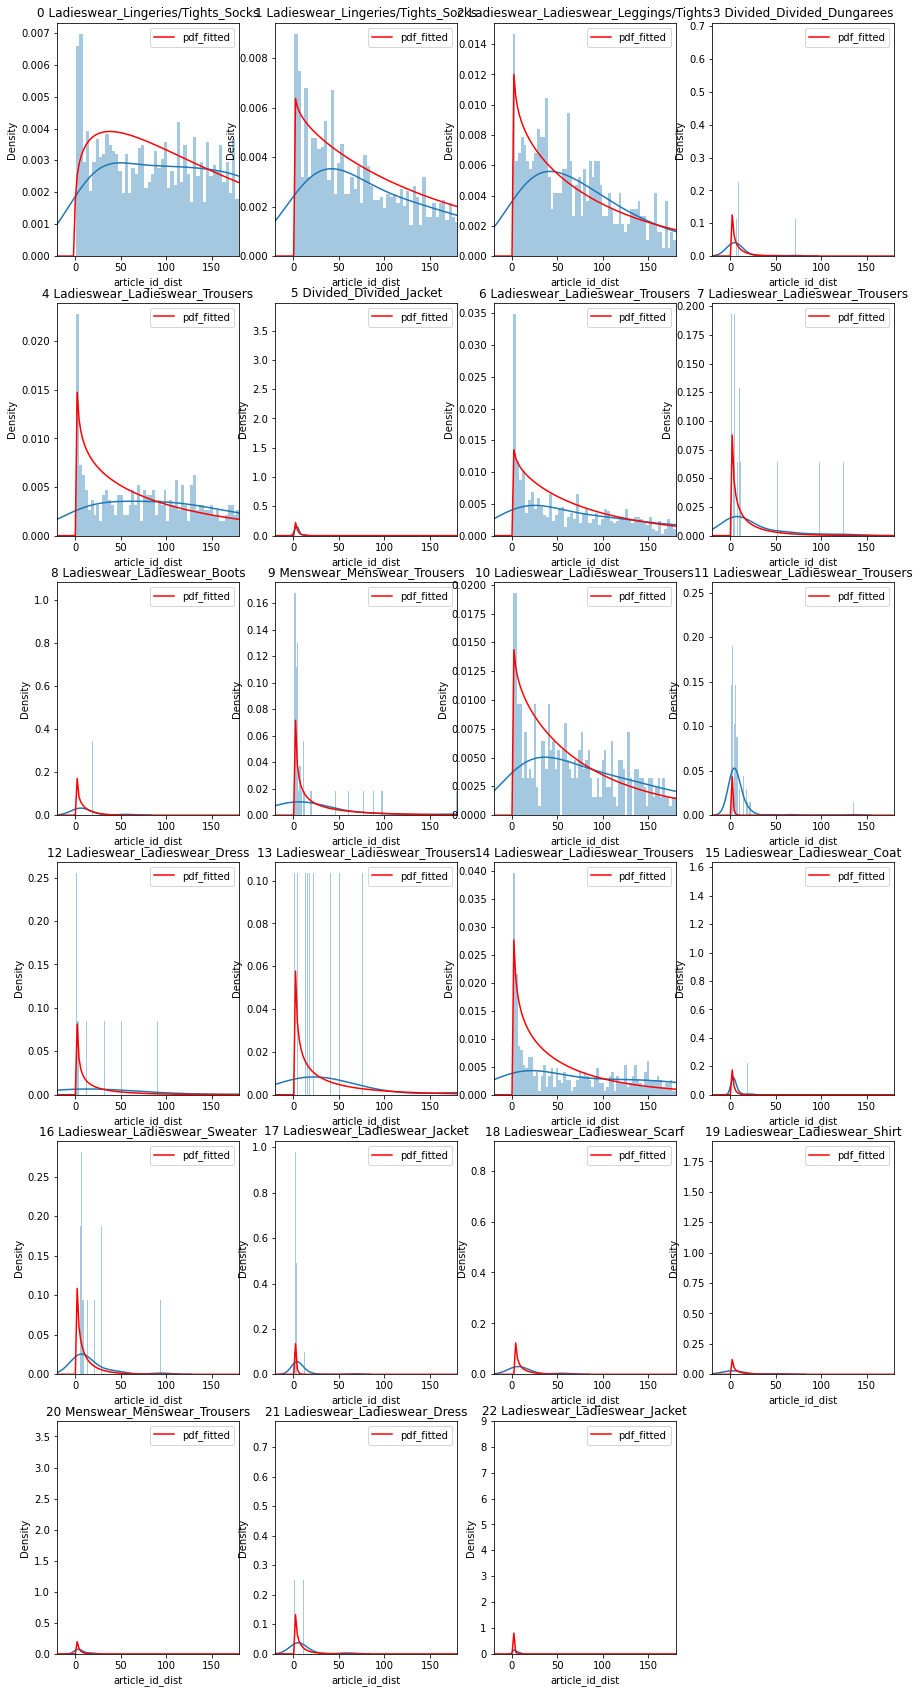

In [30]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

def estimate_distribution(data, dist_name, x_size=100):
    dist = getattr(stats, dist_name)
    params = dist.fit(data)
    mean = params[-2]
    std = params[-1]
    n = data.shape[0]
    x = np.linspace(-20, 180, x_size)
    fitted_pdf = dist.pdf(x, *params[:-2], loc=mean, scale=std) 
    return x, params, fitted_pdf


fig = plt.figure(figsize=(15,30))
for i in range(len(rp_aid)):
    cur_aid =  rp_aid.article_id.iloc[i]
    cur_aid_train_df = aid_train_df[aid_train_df.article_id == cur_aid]
    cur_dist = cur_aid_train_df.article_id_dist
    cur_dist = cur_dist[~np.isnan(cur_dist)]
    
    ax = fig.add_subplot(6, 4, i+1)
    title = art_df[art_df.article_id == cur_aid]['idxgrp_idx_prdtyp'].values[0]
    ax.set_title(f"{i} {title}")
    #sns.set(rc={'figure.figsize':(8,8)})
    plt.xlim(-20,180)
    x, params, fitted_pdf = estimate_distribution(cur_dist, 'gamma')

    # sns.distplot(dist, bins=30, norm_hist=False)
    sns.distplot(cur_dist, bins=200, norm_hist=False)
    sns.lineplot(x, fitted_pdf, color='red', label='pdf_fitted')
    


In [31]:
def get_shape_rate(row, aid_train_df):
    cur_aid =  row['article_id']
    cur_dist = aid_train_df[aid_train_df.article_id == cur_aid]['article_id_dist']
    cur_dist = cur_dist[~np.isnan(cur_dist)]
    shape, loc, scale = stats.gamma.fit(cur_dist)
    rate = (1/scale)
    return shape, rate

rp_aid[['shape', 'rate']]= rp_aid.apply(lambda x: get_shape_rate(x, aid_train_df), axis=1, result_type='expand')


In [32]:
min_num_purchased = 4
rp_cid_aid_df = aid_train_df.groupby(['customer_id', 'article_id']).agg(
    t_mean=pd.NamedAgg(column='article_id_dist', aggfunc=np.nanmean),
    t_purch=pd.NamedAgg(column='article_id_dist', aggfunc=np.nansum),
    t_last=pd.NamedAgg(column='t_dat', aggfunc='max'),
    t_first=pd.NamedAgg(column='t_dat', aggfunc='min'),
    cnt=pd.NamedAgg(column='article_id_dist', aggfunc='count'))
rp_cid_aid_df = rp_cid_aid_df.reset_index()

rp_cid_aid_df = rp_cid_aid_df[rp_cid_aid_df.cnt >= min_num_purchased]
rp_cid_aid_df = pd.merge(rp_cid_aid_df, rp_aid, on='article_id', how='left')

display(rp_cid_aid_df.sort_values('cnt', ascending=False).head(10))

,customer_id,article_id,t_mean,t_purch,t_last,t_first,cnt,denom_customer,num_customer,rcp,prod_name,idxgrp_idx_prdtyp,shape,rate
197,c87f63ab246a0d5c5b1c5f87cf694d9a35a9110030f0a1...,368979001,50.583333,607.0,2020-06-08,2018-10-10,12,1696,363,0.214033,ED Long leggings,Ladieswear_Ladieswear_Leggings/Tights,0.884132,0.007628
63,2e66e7ab67d6d29f30c39c2049bcbb8103b6b2a2a34705...,624257001,59.500000,714.0,2020-09-04,2018-09-21,12,1692,354,0.209220,&DENIM+ Skinny shaping RW,Ladieswear_Ladieswear_Trousers,0.801741,0.006665
113,647b7768be6b2caf4d5abf90e81c16d52b2a145294aad8...,624257001,59.545455,655.0,2020-08-27,2018-11-11,11,1692,354,0.209220,&DENIM+ Skinny shaping RW,Ladieswear_Ladieswear_Trousers,0.801741,0.006665
52,24998f88bd435a862764e846c934adaf72a9cda29d3d8a...,160442010,62.000000,682.0,2020-08-22,2018-10-10,11,8447,1723,0.203978,3p Sneaker Socks,Ladieswear_Lingeries/Tights_Socks,0.955485,0.005267
51,24998f88bd435a862764e846c934adaf72a9cda29d3d8a...,160442007,68.200000,682.0,2020-08-22,2018-10-10,10,9801,2180,0.222426,3p Sneaker Socks,Ladieswear_Lingeries/Tights_Socks,1.247058,0.006408
190,c1bf177697765ed6c9a5ea235588c649359fb14723fb69...,368979001,63.555556,572.0,2020-04-18,2018-09-24,9,1696,363,0.214033,ED Long leggings,Ladieswear_Ladieswear_Leggings/Tights,0.884132,0.007628
135,8543ff5a21cb63d88d8e58ac0139f317693dbf964e2fb8...,698387001,61.000000,549.0,2020-07-28,2019-01-26,9,1195,271,0.226778,&DENIM+ Skinny Shaping HW,Ladieswear_Ladieswear_Trousers,0.906758,0.010279
28,17a152d928e2e0cd52db5b0182745712b98270ca9d3861...,624257001,69.250000,554.0,2020-08-16,2019-02-09,8,1692,354,0.209220,&DENIM+ Skinny shaping RW,Ladieswear_Ladieswear_Trousers,0.801741,0.006665
204,d4ab68fdea6adb75c56cc54c18fc3abfea3f9989959562...,750330002,62.500000,500.0,2020-07-06,2019-02-22,8,1759,370,0.210347,&DENIM Skinny HW Ancle Vanessa,Ladieswear_Ladieswear_Trousers,0.739686,0.011409
0,0031a3ee9e817a6268d6bb4d598fd6922eb35f26dd0054...,160442007,93.571429,655.0,2020-09-03,2018-11-18,7,9801,2180,0.222426,3p Sneaker Socks,Ladieswear_Lingeries/Tights_Socks,1.247058,0.006408


In [33]:

val_df['t_dat'] = pd.to_datetime(val_df.t_dat)
rp_cid_aid_df['cur_date_min'] = val_df.t_dat.min()
rp_cid_aid_df['cur_date_max'] = val_df.t_dat.max()
rp_cid_aid_df['t_min'] = rp_cid_aid_df['cur_date_min'] - rp_cid_aid_df['t_last']
rp_cid_aid_df['t_max'] = rp_cid_aid_df['cur_date_max'] - rp_cid_aid_df['t_last']
rp_cid_aid_df['t_pg_min'] = rp_cid_aid_df['cur_date_min'] - rp_cid_aid_df['t_first']
rp_cid_aid_df['t_pg_max'] = rp_cid_aid_df['cur_date_max'] - rp_cid_aid_df['t_first']



/var/folders/fl/l7bfgt6j3lz29pwdkr0_537r0000gn/T/ipykernel_68559/1898847977.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_df['t_dat'] = pd.to_datetime(val_df.t_dat)


- when $t > 2 \times t_{mean}$: 
    $$\lambda_{A_{i}, C_{j}}=\frac{k+\alpha_{A_{i}}} {t+\beta_{A_{i}}}, \ \ t>0$$ 
    - $\alpha_{A_{i}}$, $\beta_{A_{i}}$ : the shape and rate parameters of the gamma prior of product ${A_{i}}$
    - k : the number of purchases of product ${A_{i}}$ by customer ${C_{j}}$; 
    - t : elapsed time between the first purchase of product ${A_{i}}$ by customer ${C_{j}}$ and the current time.
    
    
    
<br><br>

- when $t < 2 \times t_{mean}$: 
  $$ \lambda_{A_{i},C_{j}} = {{k+\alpha_{A_{i}}} \over {t_{purch} + 2  |t_{mean} \  - \ t| + \beta_{A_{i}}}} , \ \, t>0 $$
    - t : the elapsed time interval between the last purchase of product Ai by customer Cj and the current time
    - $t_{mean}$: estimated mean repeat purchase time interval between successive purchases of product Ai by customer Cj 
    - $t_{purch}$ :elapsed time interval between the first and last purchase of product Ai by customer Cj 



In [34]:
def calc_mpg_lambda(t, t_mean, t_purch, t_pg, k, alpha, beta):
    lambda_ac = None 
    if t > (t_mean * 2):
        lambda_ac = (k + alpha) / (t_pg + beta)
    else:
        lambda_ac = (k + alpha) / (t_purch + (2*abs(t_mean-t)) + beta)
    return lambda_ac
        
def get_lambda(row):
    t_min = row['t_min']/np.timedelta64(1, 'D')
    t_max = row['t_max']/np.timedelta64(1, 'D')
    k = row['cnt']
    alpha = row['shape']
    beta = row['rate']
    t_mean = row['t_mean']
    t_purch = row['t_purch']
    t_pg_min = row['t_pg_min'] /np.timedelta64(1, 'D')
    t_pg_max = row['t_pg_max'] /np.timedelta64(1, 'D')
    lambda_ac_min = calc_mpg_lambda(t_min, t_mean, t_purch, t_pg_min, k, alpha, beta)
    lambda_ac_max = calc_mpg_lambda(t_max, t_mean, t_purch, t_pg_max, k, alpha, beta)
    
    return lambda_ac_min, lambda_ac_max

#     labmda_ac = (lambda_ac_min + lambda_ac_max)/2
#     return labmda_ac
    
rp_cid_aid_df[['lambda_min','lambda_max']] = rp_cid_aid_df.apply(lambda x: get_lambda(x), axis=1, result_type='expand')



- $R_{A_{i}, C_{j}}(t)$: is a homogeneous Poisson’s process with repeat purchase rate $\lambda$. (they assume that successive repeat purchases are not correlated with each other.)
    $$R_{A_{i}, C_{j}}(t)=\sum_{m=1}^{\infty} \frac{\lambda_{A_{i}, C_{j}}^{m} \exp \left(\lambda_{A_{i}, C_{j}}\right)}{m !}, \ \ t>0$$ 


In [35]:
def calc_hpp(rate, num_loop=10):
    rac = 0
    for i in range(1,num_loop+1):
        rac += ((rate**(i)) * math.exp(rate)) / math.factorial(i)
    return rac
        

rp_cid_aid_df['R_ac_min'] = rp_cid_aid_df['lambda_min'].apply(lambda x: calc_hpp(x,100))
rp_cid_aid_df['R_ac_max'] = rp_cid_aid_df['lambda_max'].apply(lambda x: calc_hpp(x,100))

# purchase product density
rp_cid_aid_df['ppd_min'] = rp_cid_aid_df['rcp'] * rp_cid_aid_df['R_ac_min']
rp_cid_aid_df['ppd_max'] = rp_cid_aid_df['rcp'] * rp_cid_aid_df['R_ac_max']

rp_cid_aid_df = rp_cid_aid_df.sort_values('ppd_max', ascending=False)
rp_cid_aid_df.head(10)


,customer_id,article_id,t_mean,t_purch,t_last,t_first,cnt,denom_customer,num_customer,rcp,...,t_min,t_max,t_pg_min,t_pg_max,lambda_min,lambda_max,R_ac_min,R_ac_max,ppd_min,ppd_max
164,a9422cb4177ef417c8a14ea3a0e8da813a718d9f9da4a7...,160442007,41.750000,167.0,2020-06-04,2019-12-20,4,9801,2180,0.222426,...,104 days,110 days,271 days,277 days,0.019361,0.018942,0.019932,0.019488,0.004433,0.004335
207,d6c6e3db5630bfed6774c543b07e253c2a00b52cfbf9fc...,698387001,65.500000,262.0,2020-07-22,2019-11-03,4,1195,271,0.226778,...,56 days,62 days,318 days,324 days,0.017461,0.018240,0.017925,0.018746,0.004065,0.004251
135,8543ff5a21cb63d88d8e58ac0139f317693dbf964e2fb8...,698387001,61.000000,549.0,2020-07-28,2019-01-26,9,1195,271,0.226778,...,50 days,56 days,599 days,605 days,0.017350,0.017722,0.017807,0.018200,0.004038,0.004127
197,c87f63ab246a0d5c5b1c5f87cf694d9a35a9110030f0a1...,368979001,50.583333,607.0,2020-06-08,2018-10-10,12,1696,363,0.214033,...,100 days,106 days,707 days,713 days,0.018254,0.018070,0.018761,0.018567,0.004015,0.003974
204,d4ab68fdea6adb75c56cc54c18fc3abfea3f9989959562...,750330002,62.500000,500.0,2020-07-06,2019-02-22,8,1759,370,0.210347,...,72 days,78 days,572 days,578 days,0.016839,0.016459,0.017270,0.016870,0.003633,0.003549
113,647b7768be6b2caf4d5abf90e81c16d52b2a145294aad8...,624257001,59.545455,655.0,2020-08-27,2018-11-11,11,1692,354,0.209220,...,20 days,26 days,675 days,681 days,0.016077,0.016344,0.016469,0.016750,0.003446,0.003504
63,2e66e7ab67d6d29f30c39c2049bcbb8103b6b2a2a34705...,624257001,59.500000,714.0,2020-09-04,2018-09-21,12,1692,354,0.209220,...,12 days,18 days,726 days,732 days,0.015824,0.016062,0.016204,0.016454,0.003390,0.003443
248,fdd70391cc62c827ca368ae6fb1f87229f7a272a235648...,750330002,57.714286,404.0,2020-06-12,2019-05-05,7,1759,370,0.210347,...,96 days,102 days,500 days,506 days,0.016105,0.015712,0.016499,0.016087,0.003470,0.003384
51,24998f88bd435a862764e846c934adaf72a9cda29d3d8a...,160442007,68.200000,682.0,2020-08-22,2018-10-10,10,9801,2180,0.222426,...,25 days,31 days,707 days,713 days,0.014637,0.014869,0.014962,0.015205,0.003328,0.003382
52,24998f88bd435a862764e846c934adaf72a9cda29d3d8a...,160442010,62.000000,682.0,2020-08-22,2018-10-10,11,8447,1723,0.203978,...,25 days,31 days,707 days,713 days,0.015814,0.016069,0.016194,0.016461,0.003303,0.003358


In [36]:
rp_cid_aid_df.tail(10)

,customer_id,article_id,t_mean,t_purch,t_last,t_first,cnt,denom_customer,num_customer,rcp,...,t_min,t_max,t_pg_min,t_pg_max,lambda_min,lambda_max,R_ac_min,R_ac_max,ppd_min,ppd_max
126,7916a428b5b7c0c64a6e6f54454c3044a13ed2fea872b3...,160442010,145.00,580.0,2020-09-10,2019-02-08,4,8447,1723,0.203978,...,6 days,12 days,586 days,592 days,0.005776,0.005858,0.005826,0.005909,0.001188,0.001205
92,4d68367d3a052136323d4e8796f93284d0250328aa5eeb...,160442010,163.50,654.0,2020-07-19,2018-10-04,4,8447,1723,0.203978,...,59 days,65 days,713 days,719 days,0.005742,0.005823,0.005792,0.005874,0.001181,0.001198
128,7c101f6cb75a0f2f7c11015ddfbd0a02100c357bb29390...,160442010,155.50,622.0,2020-08-27,2018-12-14,4,8447,1723,0.203978,...,20 days,26 days,642 days,648 days,0.005549,0.005625,0.005596,0.005672,0.001141,0.001157
70,335625284c5a4e320c853fa46c063e15e734c70c943d28...,160442010,161.50,646.0,2020-08-19,2018-11-12,4,8447,1723,0.203978,...,28 days,34 days,674 days,680 days,0.005428,0.005500,0.005472,0.005546,0.001116,0.001131
38,1d60bc517c3f9c508a031d9d838262869f22214fd1a5af...,160442010,171.25,685.0,2020-08-25,2018-10-10,4,8447,1723,0.203978,...,22 days,28 days,707 days,713 days,0.005039,0.005101,0.005077,0.005140,0.001036,0.001048
142,8c1b18ced01f0c10e695ccbbdf58fc2a3a3849cd615aba...,160442010,172.00,688.0,2020-09-03,2018-10-16,4,8447,1723,0.203978,...,13 days,19 days,701 days,707 days,0.004926,0.004985,0.004962,0.005023,0.001012,0.001025
106,5c9992bc171e440f402acf7a643e1771e5ba9dd5e494a5...,160442010,171.75,687.0,2020-09-06,2018-10-20,4,8447,1723,0.203978,...,10 days,16 days,697 days,703 days,0.004904,0.004963,0.004940,0.005000,0.001008,0.001020
159,a00b081c2b3d12e28a575c54ced3f0f9098ec0d5810ef0...,160442010,172.25,689.0,2020-09-11,2018-10-23,4,8447,1723,0.203978,...,5 days,11 days,694 days,700 days,0.004842,0.004899,0.004877,0.004935,0.000995,0.001007
69,31e87596b7d3b8bf490e7f3cf98a8e5322faad580de7d2...,160442010,178.50,714.0,2020-09-11,2018-09-28,4,8447,1723,0.203978,...,5 days,11 days,719 days,725 days,0.004671,0.004724,0.004703,0.004758,0.000959,0.000970
124,75090d88eef767afd63d6ffbaf71ec426e944046cfae01...,160442010,179.25,717.0,2020-09-15,2018-09-29,4,8447,1723,0.203978,...,1 days,7 days,718 days,724 days,0.004616,0.004668,0.004648,0.004701,0.000948,0.000959


In [37]:

cus_ids = rp_cid_aid_df['customer_id'].values
art_ids = rp_cid_aid_df['article_id'].values

founded = 0
for i in range(len(rp_cid_aid_df)):
    num_founded =  len(val_df[(val_df.customer_id == cus_ids[i]) & 
                          (val_df.article_id == art_ids[i])])
    if num_founded > 0:
        founded +=1
        print(i)


25
103
144


In [38]:
rp_cid_aid_df.iloc[[56,82,175]]

,customer_id,article_id,t_mean,t_purch,t_last,t_first,cnt,denom_customer,num_customer,rcp,...,t_min,t_max,t_pg_min,t_pg_max,lambda_min,lambda_max,R_ac_min,R_ac_max,ppd_min,ppd_max
93,4f7a3dd5f390631134f909a1f2238f2d296b3273047efa...,698387001,63.000000,252.0,2020-02-22,2019-06-15,4,1195,271,0.226778,...,207 days,213 days,459 days,465 days,0.010690,0.010552,0.010863,0.010720,0.002463,0.002431
229,eae4ef48cf75834a5ebf1936967ea86a9cf1e1098ce8b8...,160442007,100.833333,605.0,2020-08-23,2018-12-27,6,9801,2180,0.222426,...,24 days,30 days,629 days,635 days,0.009552,0.009706,0.009690,0.009848,0.002155,0.002190
91,499e39234f416ba54848afff7eb785fbe17c8ab9193b37...,160442010,85.600000,428.0,2019-12-01,2018-09-29,5,8447,1723,0.203978,...,290 days,296 days,718 days,724 days,0.008294,0.008226,0.008398,0.008328,0.001713,0.001699


In [39]:
print(f"최소 반복 구매 횟수: {rcp_threshold}")
print(f"최소 반복 구매 횟수: {min_num_purchased}")

print(f"threshold 0일 때 정확도 {(founded / len(rp_cid_aid_df))}")

최소 반복 구매 횟수: 0.2
최소 반복 구매 횟수: 4
threshold 0일 때 정확도 0.012048192771084338



# References:
- buy it agiain paper: https://dl.acm.org/doi/pdf/10.1145/3219819.3219891
- sns.distplot.kde : https://darkpgmr.tistory.com/147
- lognormal의 파라미터
https://stackoverflow.com/questions/8747761/scipy-lognormal-distribution-parameters
- 확률분포 mle fitting 이 후, 시각화  http://incredible.ai/statistics/2015/06/13/Distribution-Estimation/
- scipy의 lognormal plot, 표준편차가 너무 클 때: https://stats.stackexchange.com/questions/239081/normal-qq-plot-of-logarithm-of-data-does-not-match-log-normal-qq-plot-of-data-it
